<a href="https://colab.research.google.com/github/NataKiseleva/KL/blob/main/CNN_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf

In [7]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from string import punctuation
punct = punctuation+'«»—…“”*№–:'

In [9]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [10]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
data = pd.read_csv('lenta_sample.csv')

In [12]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [13]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [14]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [15]:
id2word = {i:w for w, i in word2id.items()}

In [16]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
X

In [18]:
MAX_LEN = max(len(x) for x in X)

In [19]:
MAX_LEN

3578

In [20]:
MEAN_LEN = np.median([len(x) for x in X])

In [21]:
MEAN_LEN

170.0

In [22]:
MAX_LEN = int(MEAN_LEN + 50)

In [24]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [25]:
X.shape

(147852, 220)

In [26]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [27]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [28]:
len(label2id)

19

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [30]:
import gensim 
texts = data.text.apply(preprocess).tolist()

In [31]:
w2v = gensim.models.Word2Vec(texts, size=100)
w_w2v = np.zeros((len(word2id), 100))

In [32]:
for word, i in word2id.items():
    if word == 'PAD':
        continue
    
    try:
        w_w2v[i] = w2v.wv[word]
        
    except KeyError:
        w_w2v[i] = w2v.wv['нетнетнет']

In [33]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

In [48]:
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, trainable=False,
                                      weights=[w_w2v])(inputs)

In [49]:
conv1 = tf.keras.layers.Conv1D(kernel_size=32, filters=32, padding='same',strides=3)(embeddings)

In [50]:
drop1 = tf.keras.layers.Dropout(0.2)(conv1)

In [52]:
pool1 = tf.keras.layers.AveragePooling1D()(drop1) 

In [53]:
conv2 = tf.keras.layers.Conv1D(kernel_size=20, filters=15, padding='same',strides=2, 
                                  kernel_regularizer='l2', activation='relu')(pool1)

In [54]:
pool2 = tf.keras.layers.AveragePooling1D()(conv2)  

In [55]:
rnn = tf.keras.layers.GRU(512, return_sequences=False)(conv2)

In [56]:
lstm_backward =  tf.keras.layers.LSTM(512, return_sequences=False, go_backwards=True)(conv2)

In [57]:
concat_2 = tf.keras.layers.concatenate([rnn, lstm_backward], axis=1)

In [58]:
drop2 = tf.keras.layers.Dropout(0.1)(concat_2)

In [59]:
dense = tf.keras.layers.Dense(128, activation='relu')(drop2)

In [60]:
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

In [65]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1])

In [66]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 220)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 220, 100)     5529400     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 74, 32)       102432      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 74, 32)       0           conv1d_2[0][0]                   
____________________________________________________________________________________________

In [67]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01,
                                              patience=5, 
                                              verbose=1, 
                                              mode='max',
                                              )

In [69]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=100,
          callbacks=[early_stop])

Epoch 1/100
141/141 [==============================] - 72s 270ms/step - loss: 1.7699 - f1: 0.3850 - val_loss: 1.2239 - val_f1: 0.6481
Epoch 2/100
141/141 [==============================] - 37s 261ms/step - loss: 1.1519 - f1: 0.6670 - val_loss: 1.0752 - val_f1: 0.6911
Epoch 3/100
141/141 [==============================] - 37s 262ms/step - loss: 1.0440 - f1: 0.6969 - val_loss: 1.0070 - val_f1: 0.7091
Epoch 4/100
141/141 [==============================] - 37s 262ms/step - loss: 0.9811 - f1: 0.7130 - val_loss: 0.9594 - val_f1: 0.7152
Epoch 5/100
141/141 [==============================] - 37s 260ms/step - loss: 0.9330 - f1: 0.7242 - val_loss: 0.9234 - val_f1: 0.7239
Epoch 6/100
141/141 [==============================] - 37s 260ms/step - loss: 0.8977 - f1: 0.7314 - val_loss: 0.8924 - val_f1: 0.7313
Epoch 7/100
141/141 [==============================] - 37s 260ms/step - loss: 0.8703 - f1: 0.7380 - val_loss: 0.8746 - val_f1: 0.7325
Epoch 8/100
141/141 [==============================] - 37s 261

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


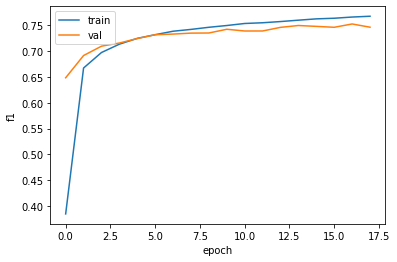

In [70]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [71]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

In [85]:
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs)

In [87]:
conv1 = tf.keras.layers.Conv1D(kernel_size=10, filters=128, strides=5)(embeddings)

In [88]:
drop1 = tf.keras.layers.Dropout(0.15)(conv1)

In [89]:
pool1 = tf.keras.layers.AveragePooling1D()(drop1)

In [90]:
conv2 = tf.keras.layers.Conv1D(kernel_size=20, filters=32, padding='same',strides=2, kernel_regularizer='l2', activation='relu')(pool1)

In [91]:
pool2 = tf.keras.layers.AveragePooling1D()(conv2)

In [92]:
rnn = tf.keras.layers.GRU(512, return_sequences=False)(pool2)

In [93]:
lstm_backward =  tf.keras.layers.LSTM(512, return_sequences=False, go_backwards=True)(pool2)

In [94]:
concat = tf.keras.layers.concatenate([rnn, lstm_backward], axis=1)

In [95]:
dense = tf.keras.layers.Dense(512, activation='relu')(concat)

In [96]:
drop2 = tf.keras.layers.Dropout(0.07)(dense)

In [97]:
dense3 = tf.keras.layers.Dense(70, activation='relu')(drop2)

In [98]:
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense3)

In [99]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1])

In [100]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 220)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 220, 200)     11058800    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 43, 128)      256128      embedding_3[0][0]                
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 43, 128)      0           conv1d_7[0][0]                   
____________________________________________________________________________________________

In [101]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', min_delta=0.01, patience=5, verbose=1, mode='max')

In [102]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1500,
          epochs=100,
          callbacks=[early_stop])

Epoch 1/100
94/94 [==============================] - 55s 544ms/step - loss: 2.1980 - f1: 0.0942 - val_loss: 1.4387 - val_f1: 0.4429
Epoch 2/100
94/94 [==============================] - 49s 525ms/step - loss: 1.1047 - f1: 0.6461 - val_loss: 1.0713 - val_f1: 0.6660
Epoch 3/100
94/94 [==============================] - 49s 525ms/step - loss: 0.8206 - f1: 0.7589 - val_loss: 1.0389 - val_f1: 0.6837
Epoch 4/100
94/94 [==============================] - 49s 526ms/step - loss: 0.5503 - f1: 0.8469 - val_loss: 1.0594 - val_f1: 0.7076
Epoch 5/100
94/94 [==============================] - 49s 523ms/step - loss: 0.3409 - f1: 0.9112 - val_loss: 1.2800 - val_f1: 0.7023
Epoch 6/100
94/94 [==============================] - 49s 522ms/step - loss: 0.2264 - f1: 0.9442 - val_loss: 1.4416 - val_f1: 0.7012
Epoch 7/100
94/94 [==============================] - 49s 520ms/step - loss: 0.1473 - f1: 0.9649 - val_loss: 1.6946 - val_f1: 0.7013
Epoch 8/100
94/94 [==============================] - 49s 517ms/step - loss: 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


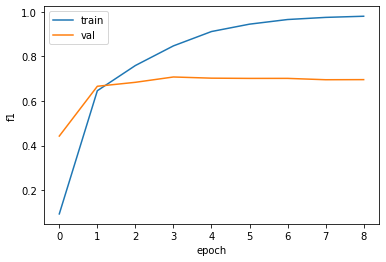

In [103]:
print(model.history.history.keys())
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()